In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install lifelines
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from lifelines import CoxPHFitter,KaplanMeierFitter
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 7.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=53a02c817e3527003ddd37bff0ee46cae815b74f5f48e82de5ef66ed97cc205a
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which i

In [ ]:
def screen_dataset(df, column_names):
    # Select only the columns specified in the column_names list
    screened_df = df[column_names]

    return screened_df

def encode(df, column):
  m = []
  for i in df[column]:
    if i == '0:LIVING':
      m.append(1)
    elif i == '1:DECEASED':
      m.append(2)
    else:
      pass
  return m

In [ ]:
tcga_data = pd.read_csv('/content/data_mrna_seq_v2_rsem.txt', sep= '\t')
CDATA =   pd.read_csv('/content/lusc_tcga_pan_can_atlas_2018_clinical_data.tsv', sep= '\t')
drug_response =  pd.read_csv('/content/LUSC_IC_Sun Jul  7 05_32_30 2024.csv')
gene_express = pd.read_csv('/content/LUSC_Genetic_features_cna_Sun Jul  7 05_32_44 2024.csv')

In [ ]:


# Ensure p53 parameters are included in the data
p53_parameters = ['ATM', 'CHEK2', 'HIPK2', 'MDM2', 'PPM1D', 'SIAH1', 'TP53', 'WSB1']
features = tcga_data[tcga_data['Hugo_Symbol'].isin(p53_parameters)]
features = features.drop('Entrez_Gene_Id',axis = 1)
features.set_index('Hugo_Symbol', inplace=True)
features = features.transpose()
print(features.head(5))
cdata = CDATA[CDATA['Sample ID'].isin(list(features.index))]
time = list(cdata['Overall Survival (Months)'])
status = encode(cdata,'Overall Survival Status')

features['Time'] = time
features['Time']  = features['Time'].fillna(0)
features['Status'] = status



Hugo_Symbol           ATM    CHEK2     HIPK2     MDM2    PPM1D     SIAH1  \
TCGA-18-3406-01   802.362  420.472   451.181  2583.46  259.055  1022.010   
TCGA-18-3407-01  1143.670  266.889   807.802  1259.75  283.539   587.745   
TCGA-18-3408-01   939.048  868.456   679.816  3464.33  352.959   848.969   
TCGA-18-3410-01  1019.380  676.303  1629.110  5226.87  363.951   467.630   
TCGA-18-3411-01   915.619  862.516   701.197  1951.93  421.603   619.310   

Hugo_Symbol          TP53     WSB1  
TCGA-18-3406-01  1196.060  1866.14  
TCGA-18-3407-01   444.815  2591.34  
TCGA-18-3408-01  2651.640  2139.11  
TCGA-18-3410-01  5145.730  3199.15  
TCGA-18-3411-01   281.605  1066.88  


     TCGA-18-3406-01  TCGA-18-3407-01  TCGA-18-3408-01  TCGA-18-3410-01  \
0.0         0.987126         0.984239         0.989546         0.989131   

     TCGA-18-3411-01  TCGA-18-3412-01  TCGA-18-3414-01  TCGA-18-3415-01  \
0.0         0.988435         0.989115         0.988619         0.986793   

     TCGA-18-3416-01  TCGA-18-3417-01  ...  TCGA-NK-A5CT-01  TCGA-NK-A5CX-01  \
0.0         0.986627          0.98391  ...         0.980586         0.986013   

     TCGA-NK-A7XE-01  TCGA-O2-A52N-01  TCGA-O2-A52Q-01  TCGA-O2-A52S-01  \
0.0         0.985482          0.97539         0.960818         0.988312   

     TCGA-O2-A52V-01  TCGA-O2-A52W-01  TCGA-O2-A5IB-01  TCGA-XC-AA0X-01  
0.0         0.983049         0.986258          0.98338         0.979228  

[1 rows x 484 columns]


<lifelines.CoxPHFitter: fitted with 484 total observations, 0 right-censored observations>
             duration col = 'Time'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 484
number of events observed = 484
   partial log-likelihood = -2502.89
         time fit was run = 2024-07-07 21:51:36 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
ATM       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
CHEK2     -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
HIPK2      0.00      1.00      0.00           -0.00            0.00                1.00                1.00
MDM2      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
PPM1D     -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
SIAH1     -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
TP53      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
WSB1       0.00      1.00      0.00            0.00            0.00                1.00                1.00

           cmp to     z    p  -log2(p)
covariate                             
ATM          0.00 -0.36 0.72      0.47
CHEK2        0.00 -1.14 0.25      1.98
HIPK2        0.00  1.19 0.23      2.11
MDM2         0.00 -0.10 0.92      0.12
PPM1D        0.00 -1.79 0.07      3.78
SIAH1        0.00 -1.05 0.29      1.77
TP53         0.00 -1.91 0.06      4.14
WSB1         0.00  2.11 0.04      4.83
---
Concordance = 0.55
Partial AIC = 5021.78
log-likelihood ratio test = 18.50 on 8 df
-log2(p) of ll-ratio test = 5.81

-5.171257295212658
0.549702844811345


<Axes: xlabel='timeline'>

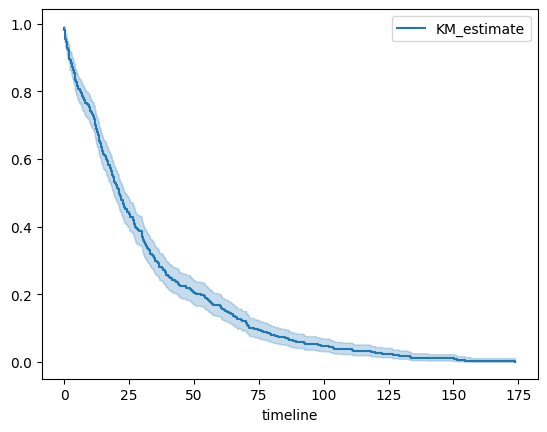

In [ ]:
cph = CoxPHFitter()
cph.fit(features, duration_col='Time', event_col='Status')


surv_data = features.drop(columns=['Time', 'Status'])
# Generate survival predictions
predictions = cph.predict_survival_function(surv_data)

print(predictions.head(1))
cph.print_summary()
print(cph.score(features))


print(cph.score(features, scoring_method="concordance_index"))

# Kaplan-Meier analysis
kmf = KaplanMeierFitter()
kmf.fit(durations=features['Time'], event_observed=features['Status'])
kmf.plot_survival_function()

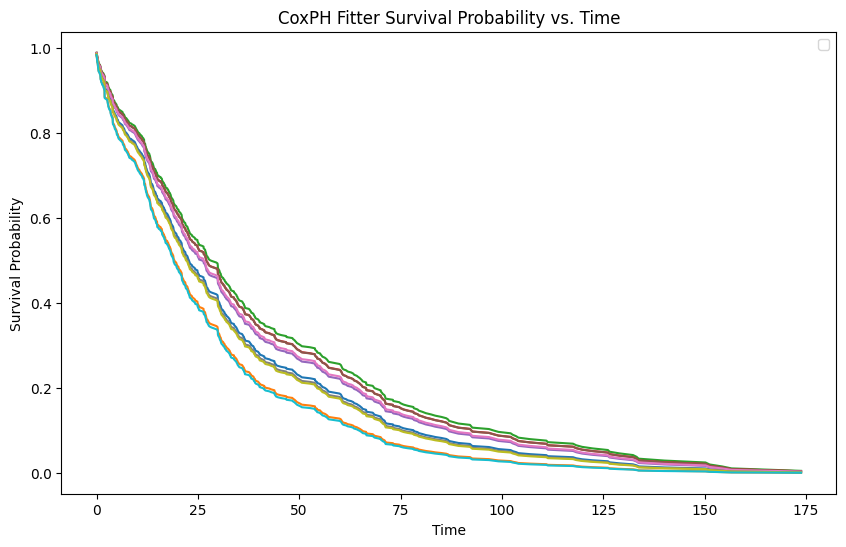

In [ ]:
# Plotting the survival function for the first observation as an example
plt.figure(figsize=(10, 6))
p = 0
for i, row in surv_data.iterrows():
    plt.plot(predictions.index, predictions[i])
    p+=1
    if p == 10:
        break

plt.title('CoxPH Fitter Survival Probability vs. Time')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

y = features['Time']
X = features.drop('Time',axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Assuming X is your input features and y is the target (e.g., drug response)
# Split data into training and testing sets (already shown in previous examples)

# Fit Linear Regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Evaluate model
y_pred = reg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) - Linear Regression: {mse}")

Mean Squared Error (MSE) - Linear Regression: 1091.6144039621497


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape
from sklearn.metrics import mean_squared_error

# Define a neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
y_pred_nn = model.predict(X_test)
print(y_pred.shape)
mse_nn = mean_squared_error(y_test, y_pred_nn)
print(f"Mean Squared Error (MSE) - Neural Network: {mse_nn}")

Epoch 1/50
13/13 [==============================] - 1s 36ms/step - loss: 267446.9062 - val_loss: 65982.2031
Epoch 2/50
13/13 [==============================] - 0s 10ms/step - loss: 127849.4297 - val_loss: 25153.9707
Epoch 3/50
13/13 [==============================] - 0s 7ms/step - loss: 87040.7266 - val_loss: 18521.2715
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 45974.9961 - val_loss: 14447.1123
Epoch 5/50
13/13 [==============================] - 0s 12ms/step - loss: 75197.8281 - val_loss: 18906.6973
Epoch 6/50
13/13 [==============================] - 0s 7ms/step - loss: 30105.7500 - val_loss: 8838.9316
Epoch 7/50
13/13 [==============================] - 0s 8ms/step - loss: 22746.1465 - val_loss: 6466.8306
Epoch 8/50
13/13 [==============================] - 0s 8ms/step - loss: 54757.7109 - val_loss: 5728.0830
Epoch 9/50
13/13 [==============================] - 0s 7ms/step - loss: 19369.8633 - val_loss: 6139.5586
Epoch 10/50
13/13 [==========================

In [ ]:

gdsc_data = pd.merge(gene_express, drug_response, on = 'Cell Line Name')
for i in gdsc_data.columns:
  print(i,gdsc_data[i].unique())

Cell Line Name ['HARA' 'HCC-15' 'NCI-H1869' 'LC-1-sq' 'LOU-NH91' 'RERF-LC-Sq1' 'EBC-1'
 'KNS-62' 'EPLC-272H' 'SK-MES-1' 'NCI-H226' 'LK-2' 'NCI-H2170' 'NCI-H520']
COSMIC ID [1240142 1240143 1240183 1298223 1298226 1298538  753554  753569  753556
  909728  905941  687787  687815  908443]
GDSC Desc1 ['lung']
GDSC Desc2 ['lung_NSCLC_squamous_cell_carcinoma']
TCGA Desc ['LUSC']
Genetic Feature ['cnaLUSC1' 'cnaLUSC2' 'cnaLUSC3' 'cnaLUSC4' 'cnaLUSC5' 'cnaLUSC6'
 'cnaLUSC7' 'cnaLUSC8' 'cnaLUSC9' 'cnaLUSC10' 'cnaLUSC11' 'cnaLUSC12'
 'cnaLUSC13' 'cnaLUSC14' 'cnaLUSC15' 'cnaLUSC16' 'cnaLUSC17' 'cnaLUSC18'
 'cnaLUSC19' 'cnaLUSC20' 'cnaLUSC21' 'cnaLUSC22' 'cnaLUSC23' 'cnaLUSC24'
 'cnaLUSC25' 'cnaLUSC26' 'cnaLUSC27' 'cnaLUSC28' 'cnaLUSC29' 'cnaLUSC30'
 'cnaLUSC31' 'cnaLUSC32' 'cnaLUSC33' 'cnaLUSC34' 'cnaLUSC35' 'cnaLUSC36'
 'cnaLUSC37' 'cnaLUSC38' 'cnaLUSC39' 'cnaLUSC40' 'cnaLUSC41' 'cnaLUSC42'
 'cnaLUSC43' 'cnaLUSC44' 'cnaLUSC45' 'cnaLUSC46' 'cnaLUSC47' 'cnaLUSC48'
 'cnaLUSC49' 'cnaLUSC50' 'cnaLUSC

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

for i in ['Genetic Feature','Genes in Segment','Cell Line Name']:
  print(i,gdsc_data[i].unique())
  oe = OrdinalEncoder()
  gdsc_data[i] = oe.fit_transform(gdsc_data[i].values.reshape(-1, 1))

Genetic Feature ['cnaLUSC1' 'cnaLUSC2' 'cnaLUSC3' 'cnaLUSC4' 'cnaLUSC5' 'cnaLUSC6'
 'cnaLUSC7' 'cnaLUSC8' 'cnaLUSC9' 'cnaLUSC10' 'cnaLUSC11' 'cnaLUSC12'
 'cnaLUSC13' 'cnaLUSC14' 'cnaLUSC15' 'cnaLUSC16' 'cnaLUSC17' 'cnaLUSC18'
 'cnaLUSC19' 'cnaLUSC20' 'cnaLUSC21' 'cnaLUSC22' 'cnaLUSC23' 'cnaLUSC24'
 'cnaLUSC25' 'cnaLUSC26' 'cnaLUSC27' 'cnaLUSC28' 'cnaLUSC29' 'cnaLUSC30'
 'cnaLUSC31' 'cnaLUSC32' 'cnaLUSC33' 'cnaLUSC34' 'cnaLUSC35' 'cnaLUSC36'
 'cnaLUSC37' 'cnaLUSC38' 'cnaLUSC39' 'cnaLUSC40' 'cnaLUSC41' 'cnaLUSC42'
 'cnaLUSC43' 'cnaLUSC44' 'cnaLUSC45' 'cnaLUSC46' 'cnaLUSC47' 'cnaLUSC48'
 'cnaLUSC49' 'cnaLUSC50' 'cnaLUSC51' 'cnaLUSC52' 'cnaLUSC53' 'cnaLUSC54']
Genes in Segment ['ADCYAP1,C18orf56,CETN1,CLUL1,COLEC12,DLGAP1,EMILIN2,ENOSF1,LPIN2,METTL4,MYL12A,MYL12B,MYOM1,NDC80,SMCHD1,TGIF1,TYMS,YES1'
 'ABHD3,ANKRD29,AQP4,C18orf8,CABLES1,CABYR,CHST9,CTAGE1,ESCO1,GATA6,GREB1L,HRH4,IMPACT,KCTD1,LAMA3,MIB1,NPC1,OSBPL1A,PSMA8,RBBP8,RIOK3,ROCK1,RP11-595B24.2,SNRPD1,SS18,TAF4B,TMEM241,TTC39C,ZNF521

In [ ]:
gdsc_data = gdsc_data.drop(columns=['COSMIC ID','GDSC Desc1', 'GDSC Desc2', 'TCGA Desc',
                                                'Recurrent Gain Loss','Tissue','Tissue Sub-type',
                                                'Drug Name', 'Cosmic ID', 'TCGA Classification',
                                                'AUC',
                                                'RMSE', 'Z score', 'Dataset Version'])

gdsc_data.head(20)

,Cell Line Name,Genetic Feature,IS Mutated,Genes in Segment,Drug ID,IC50,Max Conc
0,2.0,0.0,0,10.0,1003,-2.720645,0.1000
1,2.0,0.0,0,10.0,1004,-5.924449,0.1000
2,2.0,0.0,0,10.0,1005,2.998496,6.0000
3,2.0,0.0,0,10.0,1006,-0.545420,2.0000
4,2.0,0.0,0,10.0,1007,-6.751161,0.0125
5,2.0,0.0,0,10.0,1008,-2.962602,1.0000
6,2.0,0.0,0,10.0,1010,1.938616,2.0000
7,2.0,0.0,0,10.0,1011,3.008707,10.0000
8,2.0,0.0,0,10.0,1012,1.438983,10.0000
9,2.0,0.0,0,10.0,1013,2.329746,2.0000


In [ ]:
# Preparing data for drug response prediction
y = gdsc_data['IC50']  # threshold for IC50
X = gdsc_data.drop(columns=['IC50'])

# Train-test split
mX_train, mX_test, my_train, my_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(mX_test.shape,my_test.shape)

#Fit Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(mX_train, my_train)

# Predict drug response
y_pred = lin_reg.predict(mX_test)

# Evaluate model
mse = mean_squared_error(my_test, y_pred)
r2 = r2_score(my_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

(63035, 6) (63035,)
Mean Squared Error: 6.680163713739566
R^2 Score: 0.10261181327263558


In [ ]:
# Check dimensions
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (210114, 6)
y shape: (210114,)


In [ ]:
# Apply K-means clustering to create new features
kmeans = KMeans(n_clusters=5, random_state=42)
X['cluster'] = kmeans.fit_predict(X)

# Train-test split with new features
KX_train, KX_test, Ky_train, Ky_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Linear Regression model with clustering features
lin_reg_kmeans = LinearRegression()
lin_reg_kmeans.fit(KX_train, Ky_train)

# Predict drug response
y_pred_kmeans = lin_reg_kmeans.predict(KX_test)

# Evaluate model
mse_kmeans = mean_squared_error(Ky_test, y_pred_kmeans)
r2_kmeans = r2_score(Ky_test, y_pred_kmeans)

print(f'Linear Regression with K-means MSE: {mse_kmeans}')
print(f'Linear Regression with K-means R2: {r2_kmeans}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Linear Regression with K-means MSE: 6.584167842383495
Linear Regression with K-means R2: 0.11594820370639258


In [ ]:

# Build Neural Network model
Dmodel = Sequential([
    Dense(64, activation='relu', input_shape=(mX_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile model
Dmodel.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = Dmodel.fit(mX_train, my_train, epochs=50, batch_size=32, validation_data=(mX_test, my_test), verbose=1)

# Predict drug response
y_pred_nn1 = Dmodel.predict(mX_test)


print(y_pred_nn1.shape,  my_test.shape)
# Evaluate model
mse_nn = mean_squared_error(my_test, y_pred_nn1)
r2_nn = r2_score(my_test, y_pred_nn1)

print(f'Neural Network MSE: {mse_nn}')
print(f'Neural Network R2: {r2_nn}')


# Summary of Results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Linear Regression with K-means', 'Neural Network'],
    'MSE': [mse, mse_kmeans, mse_nn],
    'R2': [r2, r2_kmeans, r2_nn]
})

print(results)

Epoch 1/50
4597/4597 [==============================] - 13s 3ms/step - loss: 55.0388 - val_loss: 7.7701
Epoch 2/50
4597/4597 [==============================] - 13s 3ms/step - loss: 6.5198 - val_loss: 5.8829
Epoch 3/50
4597/4597 [==============================] - 15s 3ms/step - loss: 5.4393 - val_loss: 4.9841
Epoch 4/50
4597/4597 [==============================] - 13s 3ms/step - loss: 5.1523 - val_loss: 4.7607
Epoch 5/50
4597/4597 [==============================] - 13s 3ms/step - loss: 4.9298 - val_loss: 4.5073
Epoch 6/50
4597/4597 [==============================] - 12s 3ms/step - loss: 4.8550 - val_loss: 4.5984
Epoch 7/50
4597/4597 [==============================] - 13s 3ms/step - loss: 5.1085 - val_loss: 4.9196
Epoch 8/50
4597/4597 [==============================] - 13s 3ms/step - loss: 5.2032 - val_loss: 4.8135
Epoch 9/50
4597/4597 [==============================] - 14s 3ms/step - loss: 4.8894 - val_loss: 4.6269
Epoch 10/50
4597/4597 [==============================] - 14s 3ms/step - 

In [ ]:
gdsc_data


,Cell Line Name,Genetic Feature,IS Mutated,Genes in Segment,Drug ID,IC50
0,2.0,0.0,0,10.0,1003,-2.720645
1,2.0,0.0,0,10.0,1004,-5.924449
2,2.0,0.0,0,10.0,1005,2.998496
3,2.0,0.0,0,10.0,1006,-0.545420
4,2.0,0.0,0,10.0,1007,-6.751161
...,...,...,...,...,...,...
210109,11.0,49.0,0,31.0,2362,5.203458
210110,11.0,49.0,0,31.0,2438,10.458931
210111,11.0,49.0,0,31.0,2439,9.844085
210112,11.0,49.0,0,31.0,2498,8.383537


from matplotlib import pyplot as plt
gdsc_data['Cell Line Name'].plot(kind='hist', bins=20, title='Cell Line Name')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gdsc_data['Genetic Feature'].plot(kind='hist', bins=20, title='Genetic Feature')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gdsc_data['IS Mutated'].plot(kind='hist', bins=20, title='IS Mutated')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gdsc_data['Genes in Segment'].plot(kind='hist', bins=20, title='Genes in Segment')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gdsc_data.plot(kind='scatter', x='Cell Line Name', y='Genetic Feature', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gdsc_data.plot(kind='scatter', x='Genetic Feature', y='IS Mutated', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gdsc_data.plot(kind='scatter', x='IS Mutated', y='Genes in Segment', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gdsc_data.plot(kind='scatter', x='Genes in Segment', y='Drug ID', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
gdsc_data['Cell Line Name'].plot(kind='line', figsize=(8, 4), title='Cell Line Name')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
gdsc_data['Genetic Feature'].plot(kind='line', figsize=(8, 4), title='Genetic Feature')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
gdsc_data['IS Mutated'].plot(kind='line', figsize=(8, 4), title='IS Mutated')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
gdsc_data['Genes in Segment'].plot(kind='line', figsize=(8, 4), title='Genes in Segment')
plt.gca().spines[['top', 'right']].set_visible(False)